In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%run imports.py

In [4]:
from tqdm.notebook import tqdm

In [5]:
from paper_meta import *

In [16]:
import argparse

In [25]:
import argparse
parser = argparse.ArgumentParser('MNIST/CartPole experiments')
parser.add_argument('--env')
parser.add_argument('--algo')
parser.add_argument('--seed', default=0)
args = parser.parse_args('--env mnist --algo nsmr --seed 0'.split())


class MNISTNet(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=3)
        self.conv3 = nn.Conv2d(10, 10, kernel_size=3)
        self.fc1 = nn.Linear(10, 10)
        self.fc2 = nn.Linear(10, 10)

    def forward(self, x):
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv2(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 10)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
CartPoleNet = nn.Sequential(nn.Linear(4, 128), nn.ReLU(), 
                            nn.Linear(128, 2), nn.Softmax(dim=-1))

env2net = {'mnist': MNISTNet, 'cartpole': CartPoleNet}
net = env2net[args.env]()
n_dim = util.count_params(net)
net = net.to(device)

def fit_mnist(pop):
    bs = pop.shape[:-1]
    pop = pop.reshape(-1, n_dim)
    pop = pop.to(device)
    fit = task.calc_pop_fitness(pop, geno2pheno=lambda x: util.vec2model(x, net), device=device)
    return torch.from_numpy(fit.sel(metric='loss').data).reshape(*bs)

def fit_cartpole(x, n_sample=1):
    bs = x.shape[:-1]
    x = x.reshape(-1, x.shape[-1])
    
    agent = CartPoleAI().to(x.device)
    rs = []
    
    for xi in x:
        agent = util.vec2model(xi, agent)
        for seed in range(n_sample):
            r=0
            env = gym.make("CartPole-v0")
            obs = env.reset()
            for _ in range(250):
                inp = torch.from_numpy(obs).reshape(1, -1).float().to(x.device)
                out = agent(inp).detach().cpu().numpy()[0]
                action = np.random.choice(range(2), size=1, p=out).item()
                obs, reward, done, info = env.step(action)
                r += reward
                if(done):
                    break
            rs.append(r)
    rs = torch.tensor(rs).reshape(*bs, n_sample).mean(dim=-1).to(x)
    return -rs

def run_experiment_mnist(seed, algo):
    config = {'seed': seed, 'algo': algo}
    
    do_seed(seed)
    pop = torch.randn(101, n_dim)/10.
    a = algo2algo_fn[algo](pop, fit_mnist, 10)
    pops, fits, mrs = a[:3]
    
    data = {'pops': pops, 'fits': fits, 'mrs': mrs}
    torch.save(config, f'/work/08258/akumar01/maverick2/evolved-neuroevolution/data/mnist/config_{algo}_{seed}.pt')
    torch.save(data, f'/work/08258/akumar01/maverick2/evolved-neuroevolution/data/mnist/data_{algo}_{seed}.pt')

# run_experiment_mnist(args.seed, args.algo)

In [5]:
task = mnist.MNIST()
task.load_all_data()

/work2/08258/akumar01/maverick2/env/lib64/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [17]:
class Net(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=3)
        self.conv3 = nn.Conv2d(10, 10, kernel_size=3)
        self.fc1 = nn.Linear(10, 10)
        self.fc2 = nn.Linear(10, 10)

    def forward(self, x):
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv2(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 10)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
n_dim = util.count_params(Net())

device = 'cuda:0'
net = models_pheno.BigConvNet()
net = net.to(device)
def fit_mnist(pop):
    bs = pop.shape[:-1]
    pop = pop.reshape(-1, n_dim)
    pop = pop.to(device)
    fit = task.calc_pop_fitness(pop, geno2pheno=lambda x: util.vec2model(x, net), device=device)
    return torch.from_numpy(fit.sel(metric='loss').data).reshape(*bs)
optim_fn = fit_mnist

def run_experiment_mnist(seed, algo):
    config = {'seed': seed, 'algo': algo}
    
    do_seed(seed)
    pop = torch.randn(101, n_dim)/10.
    a = algo2algo_fn[algo](pop, fit_mnist, 10, tqdm=partial(tqdm, leave=False))
    pops, fits, mrs = a[:3]
    
    data = {'pops': pops, 'fits': fits, 'mrs': mrs}
    torch.save(config, f'/work/08258/akumar01/maverick2/evolved-neuroevolution/data/mnist/config_{algo}_{seed}.pt')
    torch.save(data, f'/work/08258/akumar01/maverick2/evolved-neuroevolution/data/mnist/data_{algo}_{seed}.pt')


for seed in tqdm(range(10), leave=True):
    for algo in tqdm(algos_normal, leave=False):
        run_experiment_mnist(seed, algo)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

TypeError: re_1c() got an unexpected keyword argument 'tqdm'

In [38]:
x = torch.randn(21, n_dim)/10.
mrs = torch.logspace(-3, -1, 32)
x, xmut, fit_diff = get_mrs_fitness(x, mrs, fit_mnist, n_samples=None)

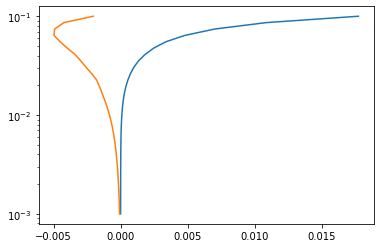

In [39]:
plt.plot(fit_diff.mean(dim=-1), mrs)
plt.plot(fit_diff.min(dim=-1).values, mrs)
plt.yscale('log')

In [34]:
viz.plot_mean_std(f, 'gsmr', 'r', )

<function viz.plot_mean_std(f, name, c, logscale=False, render_mean=True, render_std=True, render_plots=True)>

In [75]:
pop = torch.randn(21, n_dim)/10.

optim_fn = fit_mnist
n_gen = 500
n_seeds = 1

algos = algos_normal
algos_test = ['gsmr', 'nsmr']

data = []
for seed in range(n_seeds):
    do_seed(0)
    pop = torch.randn(101, n_dim)/10.
    for algo in tqdm(algos_test):
        do_seed(seed)
        res = algo2algo_fn[algo](pop, optim_fn, n_gen, tqdm=tqdm)
        pops, fits, mrs = res[:3]
        fits = fits.min(dim=-1).values
        data.append((fits, mrs))



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [105]:
fits_gsmr = data[0][0]
mrs_gsmr = data[0][1]
fits_nsmr = data[1][0]
mrs_nsmr = data[1][1]

In [110]:
mrs_gsmr.shape, mrs_nsmr.shape

(torch.Size([501, 10, 1]), torch.Size([501, 101, 1]))

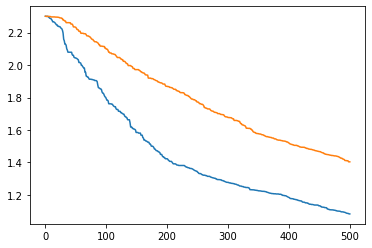

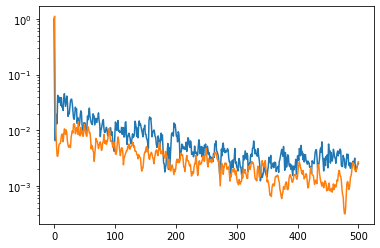

In [112]:
plt.plot(fits_gsmr)
plt.plot(fits_nsmr)
plt.show()
plt.plot(mrs_gsmr[..., 0].log().mean(dim=-1).exp())
plt.plot(mrs_nsmr[..., 0].log().mean(dim=-1).exp())
plt.yscale('log')

In [119]:
import gym
env = gym.make('CartPole-v0')
obs = env.reset()
obs

array([-0.01711477, -0.04507697,  0.01603106,  0.02484496])

In [42]:
class CartPoleAI(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc = nn.Sequential(
                        nn.Linear(4, 128),
                        nn.ReLU(),
                        nn.Linear(128, 2),
                        nn.Softmax(dim=-1), )
        def forward(self, x):
            x = self.fc(x)
            return x
n_dim = util.count_params(CartPoleAI())
agents = [CartPoleAI()]*101

def fit_cartpole(x, n_sample=1):
    bs = x.shape[:-1]
    x = x.reshape(-1, x.shape[-1])
    
    agent = CartPoleAI().to(x.device)
    rs = []
    
    for xi in x:
        agent = util.vec2model(xi, agent)
        for seed in range(n_sample):
            r=0
            env = gym.make("CartPole-v0")
            obs = env.reset()
            for _ in range(250):
                inp = torch.from_numpy(obs).reshape(1, -1).float().to(x.device)
                out = agent(inp).detach().cpu().numpy()[0]
                action = np.random.choice(range(2), size=1, p=out).item()
                obs, reward, done, info = env.step(action)
                r += reward
                if(done):
                    print(done)
                    break
            rs.append(r)
    rs = torch.tensor(rs).reshape(*bs, n_sample).mean(dim=-1).to(x)
    return -rs

import gym
fit_cartpole(data['pops'][-1][3])


True


tensor(-200.)

In [28]:
data['pops'][-1]

torch.Size([11, 898])

In [205]:
fit_cartpole_10 = partial(fit_cartpole, n_sample=10)
pop = torch.randn(11, n_dim).cuda()/10.
pops, fits = optim.run_evolution_base(pop, fit_cartpole_10, 1000, mr=1e-2, tqdm=tqdm)

  0%|          | 0/1000 [00:00<?, ?it/s]

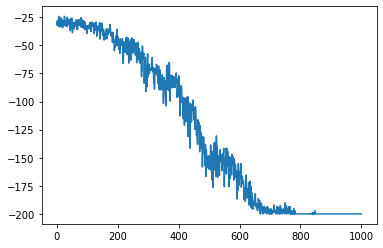

In [212]:
plt.plot(fits.min(dim=-1).values.cpu().numpy())

In [13]:
task = 'acrobot'
data = {}
# algos_render = subtract_list(algos_normal, ['1cmr'])
algos_render = ['15mr', 'ucb_5', 'gsmr', 'nsmr', 'ucb_10']
for algo in tqdm(algos_render):
    data[algo] = {'fits': [], 'mrs': []}
    for seed in range(5):
        config = torch.load(f'/work/08258/akumar01/maverick2/evolved-neuroevolution/data/{task}/config_{algo}_{seed}.pt')
        d = torch.load(f'/work/08258/akumar01/maverick2/evolved-neuroevolution/data/{task}/data_{algo}_{seed}.pt')
        data[algo]['fits'].append(d['fits'])
        data[algo]['mrs'].append(d['mrs'])
    data[algo]['fits'] = torch.stack(data[algo]['fits'])
    data[algo]['mrs'] = torch.stack(data[algo]['mrs'])


  0%|          | 0/5 [00:00<?, ?it/s]

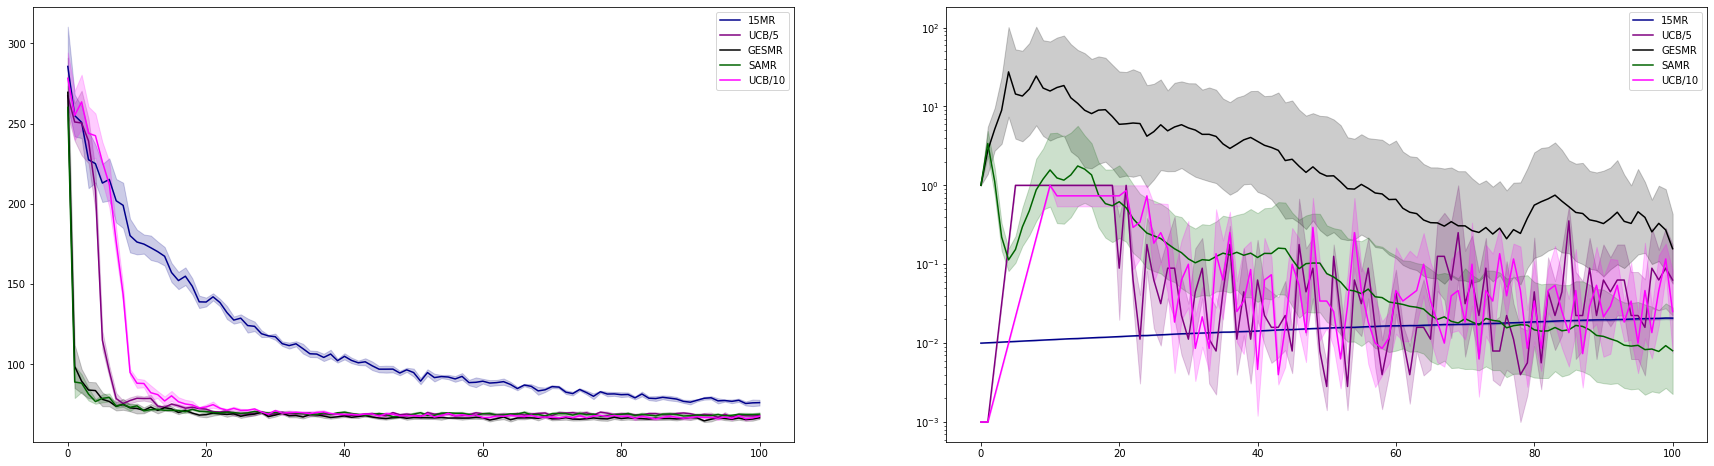

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(30,8))
for algo in algos_render:
    plt.sca(axs[0])
    viz.plot_mean_std(data[algo]['fits'], c=algo2color[algo], name=algo2label[algo],
                      render_plots=False, use_std_error=True)
    plt.sca(axs[1])
    viz.plot_mean_std(data[algo]['mrs'], c=algo2color[algo], name=algo2label[algo], logscale=True,
                      render_plots=False, use_std_error=True)
plt.legend()

In [44]:
import gym
env = gym.make('MountainCar-v0')

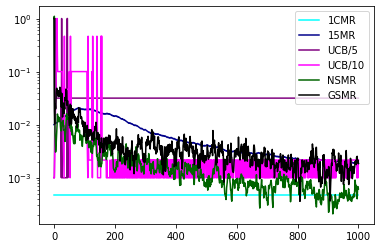

In [283]:
i=0
for algo in algos_normal:
    for seed in range(5):
        mi = m[i]
        if mi.ndim>2:
            mi = mi[..., 0]
        if mi.ndim>1:
            mi = mi.log().mean(dim=-1).exp()
        if seed==0:
            plt.plot(mi, label=algo2label[algo], c=algo2color[algo])
        i+=1
plt.yscale('log')
plt.legend()

In [43]:
import torch
import matplotlib.pyplot as plt

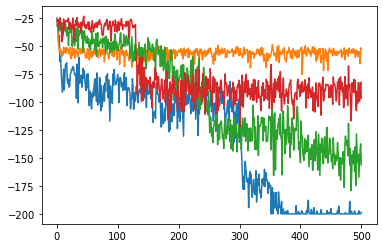

In [52]:
for seed in [0,1,2, 3]:
    data = torch.load(f'/work/08258/akumar01/maverick2/evolved-neuroevolution/data/cartpole/data_gsmr_{seed}.pt')
    plt.plot(data['fits'].min(dim=-1).values)

In [76]:
for algo_i, algo in enumerate(algos_test):
    a = torch.stack(data).reshape(1, len(algos_test), -1)[:, algo_i, :]
    viz.plot_mean_std(a, algo2label[algo], algo2color[algo])
    print(a.shape)

TypeError: expected Tensor as element 0 in argument 0, but got tuple

In [ ]:
# plt.plot(fits, c=algo2color[algo], label=algo2label[algo])
# plt.legend()

In [98]:
def create_experiment1_config():
    optim_fns = [ackley, rastrigin, rosenbrock, sphere, lin_fn]
    n_dims = [2, 30, 100, 1000]
    # init_pop_vars = [.1, 1, 5, 10]
    init_pop_vars = [1, 10]
    n_seed = 1
    n_gen = 500
    n_pop = 101

    config = []

    for optim_fn in optim_fns:
        for n_dim in n_dims:
            for init_pop_var in init_pop_vars:
#                 for algo in algos_normal:
                for algo in ['gsmr']:
                    ng = n_gen
                    if optim_fn==lin_fn:
                        ng = 100
                    elif optim_fn==ackley and n_dim==1000:
                        ng = 4000
                    config_i = {
                        'optim_fn': optim_fn,
                        'n_dim': n_dim,
                        'init_pop_var': init_pop_var,
                        'n_gen': ng,
                        'n_pop': n_pop,
                        'algo': algo,
                        'n_seed': n_seed,
                    }
                    config.append(config_i)

    data = []
    
    for ci in config:
        di = np.zeros((ci['n_seed'], ci['n_gen']+1, 2))
        di = xr.DataArray(di, dims=('seed', 'gen', 'fits_mrs'),
                            coords={'seed': list(range(ci['n_seed'])),
                                    'gen': list(range(ci['n_gen']+1)),
                                    'fits_mrs': ['fits', 'mrs']})
        data.append(di)
    return config, data
config, data = create_experiment1_config()

In [99]:
for ci, di in zip(tqdm(config), data):
    for seed in range(ci['n_seed']):
        do_seed(0)
        pop = torch.randn(ci['n_pop'], ci['n_dim'])*ci['init_pop_var']
        res = algo2algo_fn[ci['algo']](pop, ci['optim_fn'], ci['n_gen'])
        pops, fits, mrs = res[:3]
        fits = fits.min(dim=-1).values
        while mrs.ndim>1:
            mrs = mrs.log().mean(dim=-1).exp()
        
        a = di.sel(seed=seed, fits_mrs='fits')
        a[:] = fits.detach().cpu().numpy()
        a = di.sel(seed=seed, fits_mrs='mrs')
        a[:] = mrs.detach().cpu().numpy()


  0%|          | 0/40 [00:00<?, ?it/s]

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 1000, 'init_pop_var': 10, 'n_gen': 10000, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


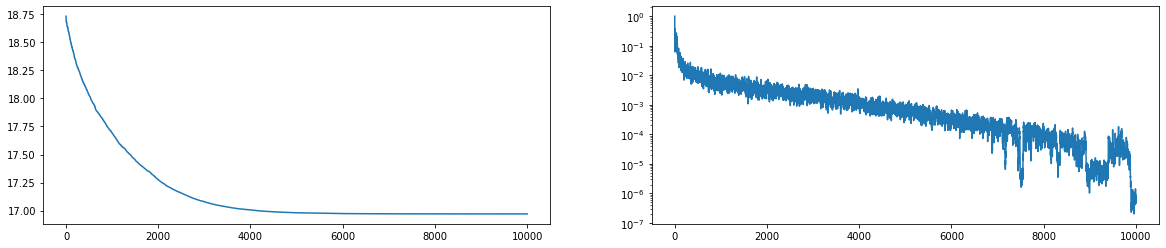

In [109]:
print(config[7])
plt.figure(figsize=(20,4))
plt.subplot(121);plt.plot(data[7][0, :, 0])
plt.subplot(122);plt.plot(data[7][0, :, 1])
plt.yscale('log')

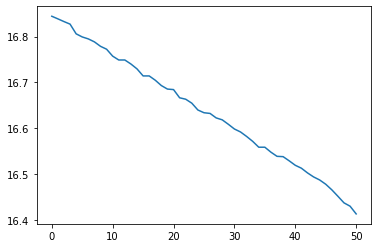

In [122]:
pop = torch.randn(101, 40)*10.
pops, fits = optim.run_evolution_base(pop, ackley, 50, mr=1e-2)
plt.plot(fits.min(dim=-1).values);

In [123]:
fits.shape

torch.Size([51, 101])

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 2, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


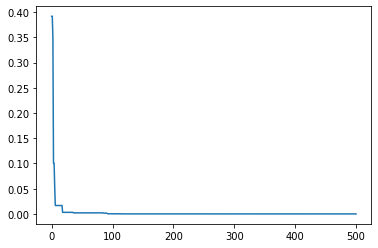

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 2, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


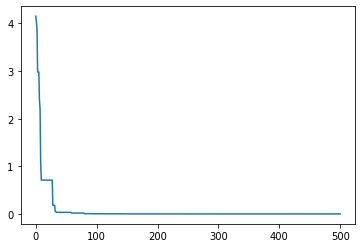

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 30, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


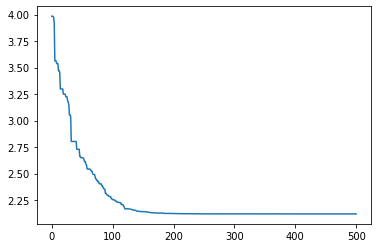

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 30, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


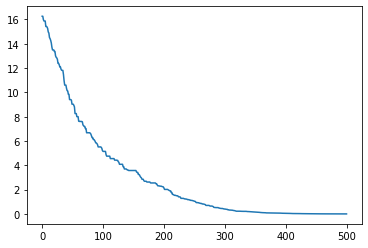

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 100, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


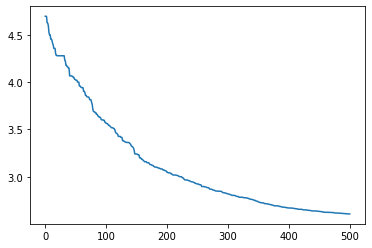

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 100, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


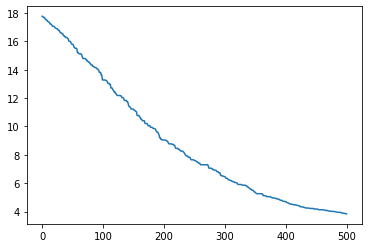

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 1000, 'init_pop_var': 1, 'n_gen': 10000, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


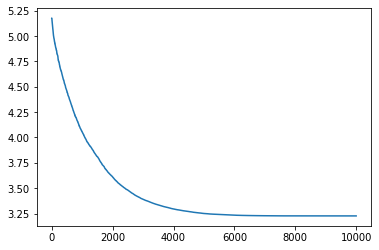

{'optim_fn': <function ackley at 0x2b9480ad4b70>, 'n_dim': 1000, 'init_pop_var': 10, 'n_gen': 10000, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


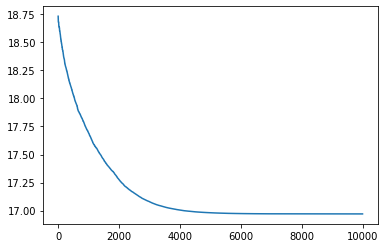

{'optim_fn': <function rastrigin at 0x2b9480ad4c80>, 'n_dim': 2, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


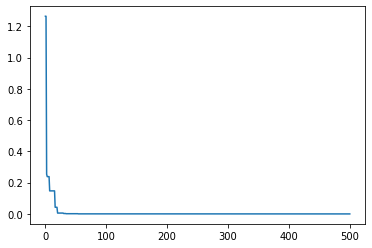

{'optim_fn': <function rastrigin at 0x2b9480ad4c80>, 'n_dim': 2, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


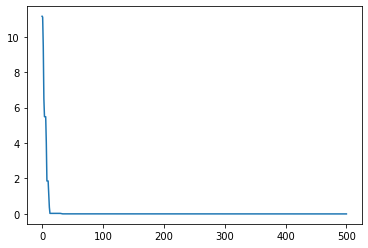

{'optim_fn': <function rastrigin at 0x2b9480ad4c80>, 'n_dim': 30, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


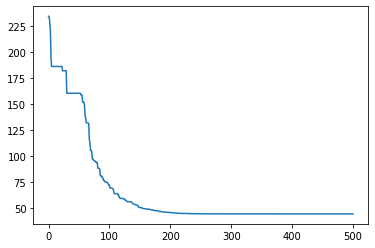

{'optim_fn': <function rastrigin at 0x2b9480ad4c80>, 'n_dim': 30, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


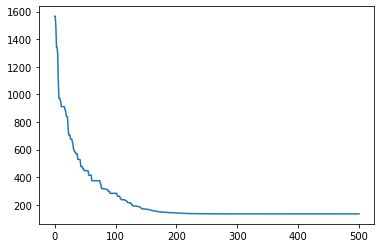

{'optim_fn': <function rastrigin at 0x2b9480ad4c80>, 'n_dim': 100, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


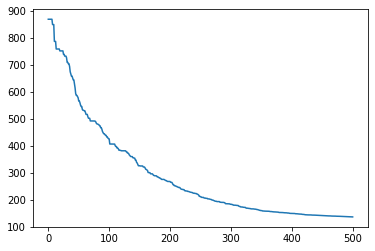

{'optim_fn': <function rastrigin at 0x2b9480ad4c80>, 'n_dim': 100, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


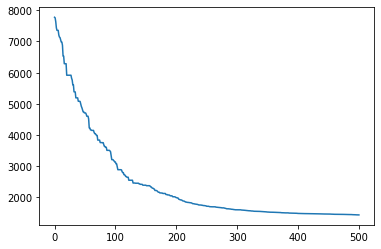

{'optim_fn': <function rastrigin at 0x2b9480ad4c80>, 'n_dim': 1000, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


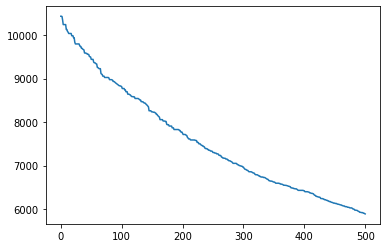

{'optim_fn': <function rastrigin at 0x2b9480ad4c80>, 'n_dim': 1000, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


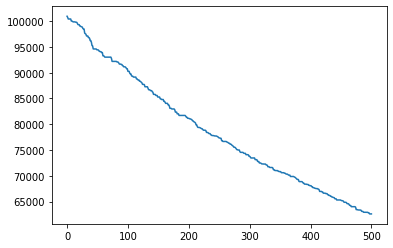

{'optim_fn': <function rosenbrock at 0x2b9480af2158>, 'n_dim': 2, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


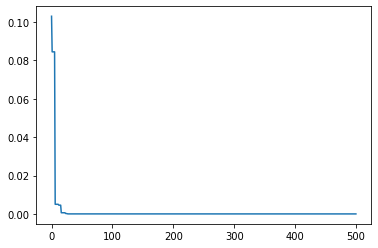

{'optim_fn': <function rosenbrock at 0x2b9480af2158>, 'n_dim': 2, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


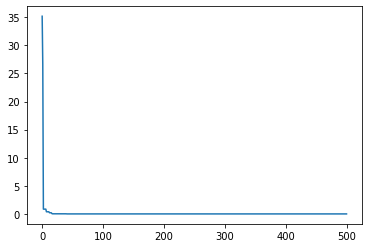

{'optim_fn': <function rosenbrock at 0x2b9480af2158>, 'n_dim': 30, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


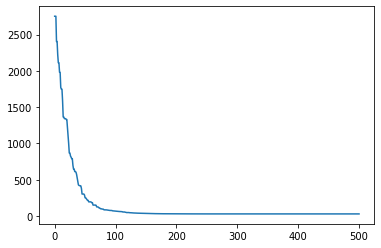

{'optim_fn': <function rosenbrock at 0x2b9480af2158>, 'n_dim': 30, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


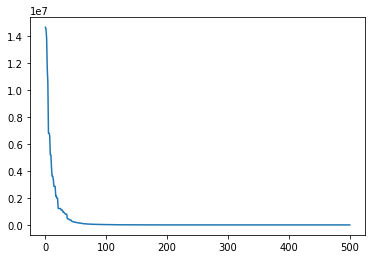

{'optim_fn': <function rosenbrock at 0x2b9480af2158>, 'n_dim': 100, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


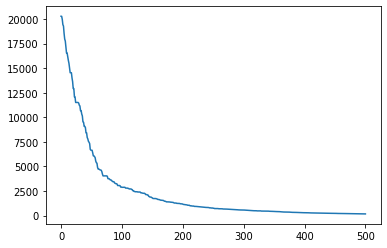

{'optim_fn': <function rosenbrock at 0x2b9480af2158>, 'n_dim': 100, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


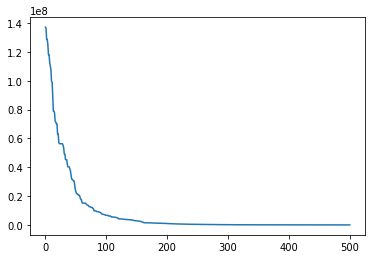

{'optim_fn': <function rosenbrock at 0x2b9480af2158>, 'n_dim': 1000, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


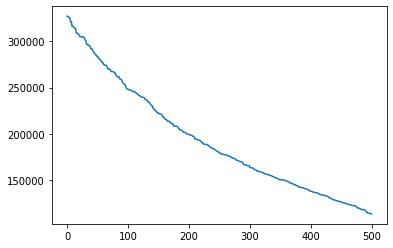

{'optim_fn': <function rosenbrock at 0x2b9480af2158>, 'n_dim': 1000, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


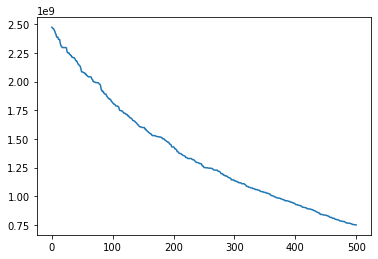

{'optim_fn': <function sphere at 0x2b9480af20d0>, 'n_dim': 2, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


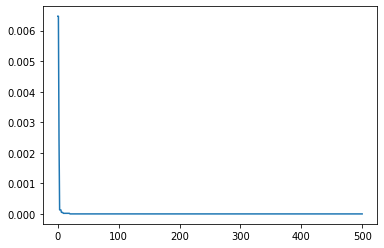

{'optim_fn': <function sphere at 0x2b9480af20d0>, 'n_dim': 2, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


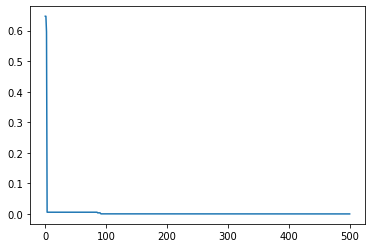

{'optim_fn': <function sphere at 0x2b9480af20d0>, 'n_dim': 30, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


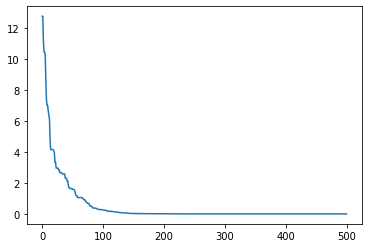

{'optim_fn': <function sphere at 0x2b9480af20d0>, 'n_dim': 30, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


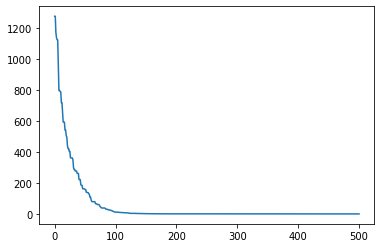

{'optim_fn': <function sphere at 0x2b9480af20d0>, 'n_dim': 100, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


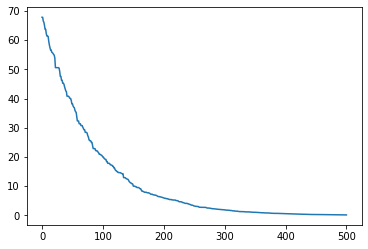

{'optim_fn': <function sphere at 0x2b9480af20d0>, 'n_dim': 100, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


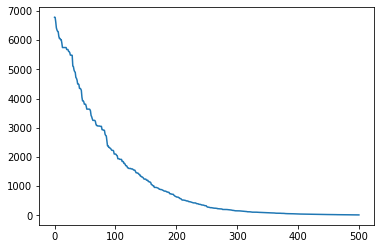

{'optim_fn': <function sphere at 0x2b9480af20d0>, 'n_dim': 1000, 'init_pop_var': 1, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


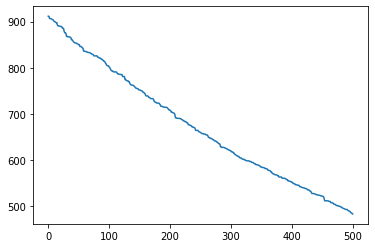

{'optim_fn': <function sphere at 0x2b9480af20d0>, 'n_dim': 1000, 'init_pop_var': 10, 'n_gen': 500, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


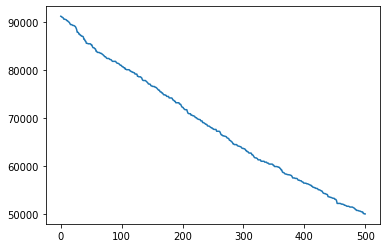

{'optim_fn': <function lin_fn at 0x2b9480af2268>, 'n_dim': 2, 'init_pop_var': 1, 'n_gen': 100, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


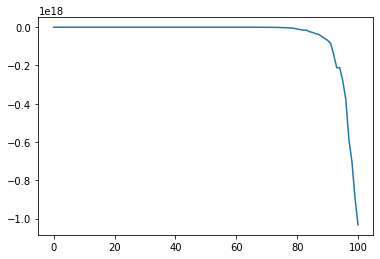

{'optim_fn': <function lin_fn at 0x2b9480af2268>, 'n_dim': 2, 'init_pop_var': 10, 'n_gen': 100, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


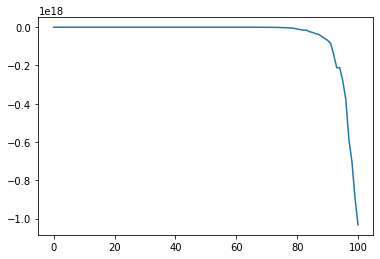

{'optim_fn': <function lin_fn at 0x2b9480af2268>, 'n_dim': 30, 'init_pop_var': 1, 'n_gen': 100, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


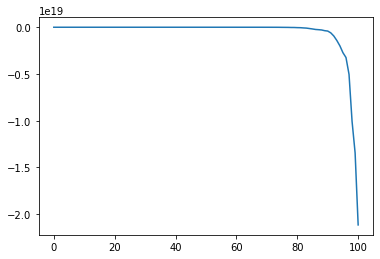

{'optim_fn': <function lin_fn at 0x2b9480af2268>, 'n_dim': 30, 'init_pop_var': 10, 'n_gen': 100, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


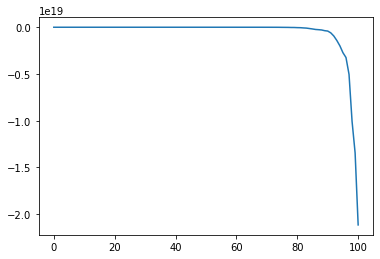

{'optim_fn': <function lin_fn at 0x2b9480af2268>, 'n_dim': 100, 'init_pop_var': 1, 'n_gen': 100, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


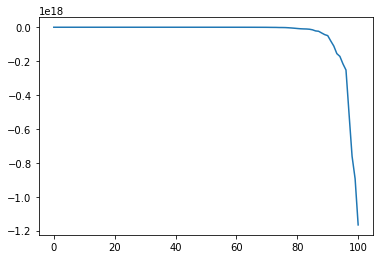

{'optim_fn': <function lin_fn at 0x2b9480af2268>, 'n_dim': 100, 'init_pop_var': 10, 'n_gen': 100, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


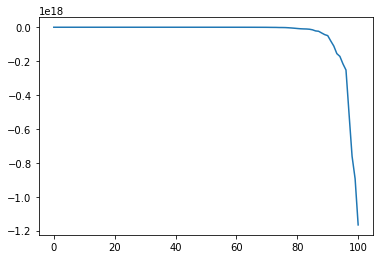

{'optim_fn': <function lin_fn at 0x2b9480af2268>, 'n_dim': 1000, 'init_pop_var': 1, 'n_gen': 100, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


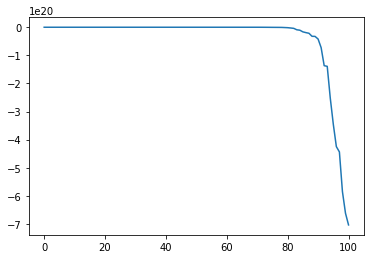

{'optim_fn': <function lin_fn at 0x2b9480af2268>, 'n_dim': 1000, 'init_pop_var': 10, 'n_gen': 100, 'n_pop': 101, 'algo': 'gsmr', 'n_seed': 1}


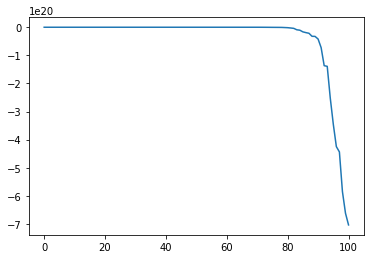

In [100]:
for ci, di in zip(config, data):
    print(ci)
    plt.plot(di[0, :, 0])
    plt.show()
    